In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import vr2p
from scipy.io import loadmat
import gcsfs
import h5py
import matplotlib.pyplot as plt
from scipy import signal
import warnings
from skimage import registration
import skimage
from skimage import metrics, transform
import cv2
from scipy.ndimage import gaussian_filter1d
from tqdm.notebook import tqdm
from scipy import interpolate, ndimage, stats
import matplotlib.cm as cm
from matplotlib import cm,colors,colormaps
from skimage.exposure import rescale_intensity
import seaborn as sns
from suite2p.registration import rigid
from scipy.fftpack import fft2, ifft2

# Helper Functions

In [6]:
##
# Helper functions
##

def array2rgb( array, disp_range,cmap):
    array = rescale_intensity(array,in_range = tuple(disp_range),out_range=(0,1)).astype(float)
    return cmap(array)

def add_weighted(im,weight):
    for i in range(3):
        im[:,:,i] *= weight
    return im

def plot_heatmap(im, d_range, colormap):
    heatmap_im = array2rgb( im, d_range,colormap)
    heatmap_im = add_weighted(heatmap_im,base_im)
    heatmap_im = np.ma.masked_where(np.isnan(heatmap_im), heatmap_im)
    #plot
    fig = plt.figure(figsize=(2.5,2.5),dpi=300)
    ax = fig.add_subplot(1, 1, 1)
    # plot img.
    ax.imshow( heatmap_im, origin='lower',extent=extent, 
              interpolation='none', vmin=0, vmax=1) # correct non uniform aspect ratio.
    ax.axis('off')
    ax.set_xlim(fov_mm[0])
    ax.set_ylim(fov_mm[1])
    # set title
    title_str = f'session (zero based): {session}\n'
    title_str += f'fov size: {fov_size_mm} mm\n'
    title_str += f'{img_type} range: {display_range[0]}-{display_range[1]}\n'
    title_str += f'heatmap range: {d_range[0]}-{d_range[1]}'
    fig.suptitle(title_str,fontsize = 2.5)
    
def get_registration_stack(animal,data, session):
    # get date of sessions for look up
    date_str = data.vr[session].info['date_time'][:10]
    date_str = date_str.replace('-','_')
    # find right folder.
    fs = gcsfs.GCSFileSystem(project='sprustonlab-meso')
    dir_list = [item['name']for item in fs.listdir(f'gs://linear-2ac/motion/Tyche-{animal}/{date_str}') if item['type']=='directory']
    assert len(dir_list)==1, f'Found multiple sessions for {animal} {date_str}'
    # get motion file.
    with fs.open(f'gs://{dir_list[0]}/MotionEstimator.me', 'rb') as handle:
        motion_data = loadmat(handle,simplify_cells=True)
    # get stacks for each stripe.
    num_stripes = len(motion_data['c'])
    stripes = []
    for stripe in motion_data['c']:
        stripe_data = np.stack([ plane for plane in stripe['roiData']['imageData']],axis=2)
        stripe_data = np.transpose(stripe_data,(1,0,2))
        stripes.append(stripe_data)
    # get offsets in pixels
    offset_pix = [] 
    for stripe_data in motion_data['c']:
        scan_field = stripe_data['roiData']['hRoi']['scanfields']
        offset = [ scan_field['pixelToRefTransform'][0,2],scan_field['pixelToRefTransform'][1,2]]
        conversion_factor = [ scan_field['pixelToRefTransform'][0,0],scan_field['pixelToRefTransform'][1,1]]
        offset_pix.append([offset[0]/conversion_factor[0], offset[1]/conversion_factor[1] ])
    offset_pix = np.array(offset_pix)
    # get stripe order on FOV
    stripe_order = offset_pix[:,0].argsort()
    stripes = [ stripes[i] for i in stripe_order]
    # get original image where stripes are in one FOV.
    original_img = data.images.original[0]['mean_img'] # image is in yx
    # create new image that will hold entire FOV stack.
    reg_stack = np.zeros((original_img.shape[0], original_img.shape[1], stripes[0].shape[2]))
    # get location of vertical lines trhough images to catch location of stripes.
    stripe_width = stripes[1].shape[1] # stripes are in yx
    stripe_mid_points = np.arange(int(stripe_width/2), original_img.shape[1], stripe_width)
    # Check pixel location along stripes
    start_x = 0
    for i_stripe, stripe_mid_point in enumerate(stripe_mid_points):
        values = original_img[:,stripe_mid_point]
        y_pixels = np.argwhere(values>0).astype(int)
        y_range = [min(y_pixels),max(y_pixels)+1]
        # fill in data.
        reg_stack[int(y_range[0]):int(y_range[1]),start_x:start_x+stripe_width,:] = stripes[i_stripe]
        start_x+=stripe_width
    return reg_stack    

def filter_nan_gaussian_conserving(arr, sigma):
    """Apply a gaussian filter to an array with nans.

    Intensity is only shifted between not-nan pixels and is hence conserved.
    The intensity redistribution with respect to each single point
    is done by the weights of available pixels according
    to a gaussian distribution.
    All nans in arr, stay nans in gauss.
    """
    nan_msk = np.isnan(arr)

    loss = np.zeros(arr.shape)
    loss[nan_msk] = 1
    loss = ndimage.gaussian_filter(
            loss, sigma=sigma, mode='constant', cval=1)

    gauss = arr.copy()
    gauss[nan_msk] = 0
    gauss = ndimage.gaussian_filter(
            gauss, sigma=sigma, mode='constant', cval=0)
    gauss[nan_msk] = np.nan

    gauss += loss * arr

    return gauss

# ratio between y and x should be 1.5
def get_offsets(data,session, stack, bin_size = [300,450], shift = [30,45],min_rois=200,verbose=False):
    img = data.images.original[session]['mean_img']
    rois = data.cells.multi_session.original[session]
    # bin size is assumed yx
    # check image size match (YX) or (height width)
    assert (img.shape[0]==stack.shape[0]) & (img.shape[1]==stack.shape[1]), 'Image sizes did not match'
    # Get roi centers.
    centers = np.vstack([roi['med'] for roi in rois]) # YX
    
    # bin image.
    offset_data = []
    for y, y_start in  enumerate(tqdm(np.arange(0,img.shape[0],shift[0]).astype(int),disable=verbose==False)):
        y_end = y_start+bin_size[0]
        if y_end>img.shape[0]: y_end=img.shape[0]
        for x, x_start in enumerate(np.arange(0,img.shape[1],shift[1]).astype(int)):
            x_end = x_start+bin_size[1]
            if x_end>img.shape[1]: x_end=img.shape[1]             
            #print('y:',y_start,'-',y_end)
            # Check if there are ROIs in this bin
            num_rois_in_bin = sum( (centers[:,0]>y_start) & (centers[:,0]<y_end) & 
                                     (centers[:,1]>x_start) & (centers[:,1]<x_end))
            if num_rois_in_bin>=min_rois:
                # Perform cross correlation calculation at all z levels
                z_img = img[y_start:y_end,x_start:x_end]
                z_img = rigid.phasecorr_reference(z_img, smooth_sigma=1)
                
                scores = []
                for z in range(stack.shape[2]):
                    z_reg_img = stack[y_start:y_end,x_start:x_end,z]
                    z_reg_img = rigid.phasecorr_reference(z_reg_img, smooth_sigma=1)
                    # check sizes match
                    assert (z_img.shape[0]==z_reg_img.shape[0]) & (z_img.shape[1]==z_reg_img.shape[1]), 'correlation images did not match in size'
                    # Convolve transformed images using multiplication
                    f_conj = np.conj(z_reg_img) * z_img

                    # Return to the spatial domain with an inverse FFT
                    corr = np.abs(ifft2(f_conj))

                    # Rearrange the normalized cross-correlation matrix so that the zero frequency is in the middle of the matrix
                    corr = np.max(np.fft.fftshift(corr))
                    #shit_pix, corr = cv2.phaseCorrelate(z_img, z_reg_img)
                    scores.append(corr)
                # calculate max offset 
                offset = 12-np.argmax(gaussian_filter1d(scores,2))
                y_pix, x_pix = np.mean([y_start,y_end]), np.mean([x_start,x_end])
                y_um, x_um = y_pix*pix_size[0], x_pix*pix_size[1]
                offset_data.append({'y':int(y),'x':int(x),'y_um': y_um, 'x_um':x_um, 'y_pix': y_pix, 'x_pix': x_pix,'offset':offset})
    offset_data = pd.DataFrame(offset_data)
    # Generate image.
    res_im = np.full((offset_data.y.max()+1, offset_data.x.max()+1),None).astype(float)
    res_im[offset_data.y, offset_data.x] = offset_data.offset
    
    return res_im, offset_data

def gen_mask_im(im, threshold=0.08):
    mask_im = (transform.resize(im,(30,45))>threshold)
    mask_im = ndimage.binary_fill_holes(mask_im).astype('float')
    mask_im = np.pad(mask_im,5)
    # resize to baseim size with added padding.
    mask_im = transform.resize(mask_im,(im.shape[0]*(1+(5/30)),
                                        im.shape[1]*(1+(5/45))),
                               mode='edge',anti_aliasing=True,anti_aliasing_sigma=1,
                                   preserve_range=False,
                                   order=1)>0.15
    # remove extra padding
    crop_loc =  [int((5/30)*im.shape[0]/2),
                  int((5/45)*im.shape[1]/2)]
    mask_im = mask_im[crop_loc[0]:crop_loc[0]+im.shape[0],
                       crop_loc[1]:crop_loc[1]+im.shape[1]]
    return mask_im

# Main Parameter

In [7]:
animal = 'A7'
pix_size = [2,1.333]
# load data.
#data = vr2p.ExperimentData(f'gs://linear-2ac/Set A/Tyche-{animal}-SetA.zarr')
data = vr2p.ExperimentData(f'gs://linear-2ac/Set A-E/Tyche-{animal}')
reg_stack = get_registration_stack(animal,data, 0)

  0%|          | 0/28 [00:00<?, ?it/s]

/home/johan/.conda/envs/vr2p/lib/python3.8/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/johan/.conda/envs/vr2p/lib/python3.8/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
/tmp/ipykernel_2284/45372304.py:167: UserWarning: Anti-aliasing standard deviation greater than zero but not down-sampling along all axes
  mask_im = transform.resize(mask_im,(im.shape[0]*(1+(5/30)),


Z offset max: 1.73, min -9.40


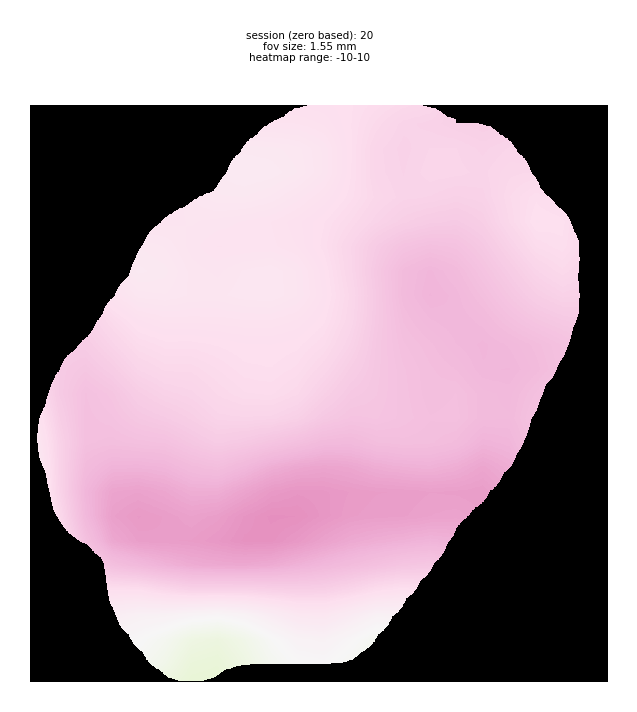

In [8]:
session=20
offset_range = [-10,10]
img_type = 'mean_img'
display_range = [250,1800]
fov_size_mm = 1.55
fov_origin_mm = [0.1,0.05] # left bottom origin.
cmap = colormaps['PiYG']
cmap.set_bad(color='black')


# get base image of FOV
base_im = rescale_intensity(data.images.original[session][img_type],
                            in_range = tuple(display_range), out_range=(0,1)).astype(float)
# fov crop in x -y
extent=[0,(base_im.shape[1]*pix_size[1])/1000, 0,(base_im.shape[0]*pix_size[0])/1000]
fov_mm = [[fov_origin_mm[0],fov_origin_mm[0] + fov_size_mm],
          [fov_origin_mm[1],fov_origin_mm[1] + fov_size_mm]] 

# get offset data.
res_im, offset_data = get_offsets(data, session, reg_stack, verbose=True, min_rois=200 )
filt_im = filter_nan_gaussian_conserving(res_im,1)
resized_im = transform.resize(filt_im, base_im.shape,anti_aliasing=False)
# mask image.
mask_im = gen_mask_im(base_im,threshold=0.05)
masked_im = np.ma.masked_where(mask_im==False, resized_im)
#plot
fig = plt.figure(figsize=(2.5,2.5),dpi=300)
ax = fig.add_subplot(1, 1, 1)
# plot img.
ax.imshow( masked_im, origin='lower',extent=extent, 
          interpolation='none',cmap=cmap,vmin=offset_range[0],vmax=offset_range[1]) # correct non uniform aspect ratio.
ax.axis('off')
ax.set_xlim(fov_mm[0])
ax.set_ylim(fov_mm[1])
# set title
title_str = f'session (zero based): {session}\n'
title_str += f'fov size: {fov_size_mm} mm\n'
title_str += f'heatmap range: {offset_range[0]}-{offset_range [1]}'
fig.suptitle(title_str,fontsize = 2.5)
print(f'Z offset max: {np.nanmax(filt_im):.02f}, min {np.nanmin(filt_im):.02f}')